<a href="https://colab.research.google.com/github/tirtharajdash/BITS-G513_MetaLearning/blob/main/Labs/Lab_2A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook has been adapted from NYU's Deep Learning Course taught by Yann LeCun & Alfredo Canziani. [Website](https://atcold.github.io/pytorch-Deep-Learning/)

This notebook covers an example of Gradient Descent, Stochastic Gradient Descent and Backpropagation without using PyTorch's Automatic Gradient Computation Capabilities.

A basic explanation of backpropagation was given in last week's lab - [Lab_1A](https://github.com/tirtharajdash/BITS-G513_MetaLearning/blob/main/Lab_1A.ipynb). For an intuitive explanation of Backpropagation check the [CS231n notes on Backpropagation](https://cs231n.github.io/optimization-2/)

# Gradient Descent

## Setup

We'll work with the classic MNIST Dataset in this notebook

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
print(X.shape, y.shape)

(70000, 784) (70000,)


In [4]:
X = X / 255

In [5]:
digits = 10
examples = y.shape[0]

y = y.reshape(1, examples)

Y_new = np.eye(digits)[y.astype('int32')]
Y_new = Y_new.T.reshape(digits, examples)

In [6]:
m = 60000
m_test = X.shape[0] - m

X_train, X_test = X[:m].T, X[m:].T
Y_train, Y_test = Y_new[:,:m], Y_new[:,m:]

shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

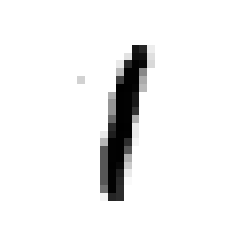

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
import matplotlib
import matplotlib.pyplot as plt

i = 1234
plt.imshow(X_train[:,i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
Y_train[:,i]

## Training

Since MNIST is a 10-class dataset, we'll be performing multi-class classification which uses the cross entropy loss function.

$$ -\sum_{c=1}^My_{o,c}\log(p_{o,c}) $$

In [18]:
import torch

from tqdm import trange

def compute_multiclass_loss(Y, Y_hat):

    L_sum = torch.sum(torch.multiply(Y, torch.log(Y_hat)))
    m = Y.shape[1]
    L = -(1/m) * L_sum

    return L

def sigmoid(z):
    s = 1 / (1 + torch.exp(-z))
    return s


Lets work with a two layer neural network with the hidden layer size being 64. We can go ahead and define them as shown below:

In [19]:
n_x = X_train.shape[0]
n_h = 64
learning_rate = 1

W1 = torch.randn(n_h, n_x)
b1 = torch.zeros((n_h, 1))
W2 = torch.randn(digits, n_h)
b2 = torch.zeros((digits, 1))

#### Training Loop

Lets simply perform full batch gradient descent. This means passing the entire dataset through the model in one go

In [20]:

X = torch.from_numpy(X_train).float()
Y = torch.from_numpy(Y_train).float()


from tqdm.notebook import tqdm
pbar = tqdm()
pbar.reset(total=100)

for i in range(100):

    ## Forward Pass

    # Y = sigma(WX + b)
    Z1 = torch.matmul(W1,X) + b1
    A1 = sigmoid(Z1)

    # Layer 2
    Z2 = torch.matmul(W2,A1) + b2
    
    # Softmax
    A2 = torch.exp(Z2) / torch.sum(np.exp(Z2), axis=0)

    # Compute Loss
    cost = compute_multiclass_loss(Y, A2)

    ## Backward Pass

    # Backpropagate to layer 2
    dZ2 = A2-Y
    dW2 = (1./m) * torch.matmul(dZ2, A1.T)
    db2 = (1./m) * torch.sum(dZ2, axis=1, keepdims=True)

    # Backpropagate to layer 1
    dA1 = torch.matmul(W2.T, dZ2)
    dZ1 = dA1 * sigmoid(Z1) * (1 - sigmoid(Z1))
    dW1 = (1./m) * torch.matmul(dZ1, X.T)
    db1 = (1./m) * torch.sum(dZ1, axis=1, keepdims=True)

    # Update variables
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1

    pbar.set_description('Epoch %i' % i)
    pbar.set_postfix(loss=cost.item())
    pbar.update()

    # if (i % 100 == 0):
    #     print("Epoch", i, "cost: ", cost.item())

print("Final Cost:", cost.item())

KeyboardInterrupt: ignored

## Testing our trained model

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

X_test = torch.from_numpy(X_test).float()

Z1 = torch.matmul(W1, X_test) + b1
A1 = sigmoid(Z1)
Z2 = torch.matmul(W2, A1) + b2
A2 = torch.exp(Z2) / torch.sum(np.exp(Z2), axis=0)

predictions = torch.argmax(A2, axis=0)
labels = torch.argmax(torch.from_numpy(Y_test), axis=0)

print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1022
           1       0.95      0.95      0.95      1144
           2       0.76      0.78      0.77       997
           3       0.77      0.76      0.76      1017
           4       0.77      0.75      0.76      1004
           5       0.63      0.65      0.64       855
           6       0.83      0.84      0.84       945
           7       0.79      0.83      0.81       986
           8       0.70      0.70      0.70       975
           9       0.73      0.70      0.71      1055

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



## Stochastic Gradient Descent

The difference between Stochatic Gradient Descent and Gradient Descent is that in SGD we do not pass the entire dataset at once. So we can define a function which returns us random splits

In [13]:
def return_partitions(X, y, batch_size):
    total_samples = X.shape[1]

    assert total_samples % batch_size == 0
    partitions = int(total_samples / batch_size)

    return torch.split(X, batch_size, dim=1), torch.split(y, batch_size, dim=1)

def partition(X, y, indices):
    return X[:, indices], y[:, indices]

In [14]:
px, py = return_partitions(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float(), 200)

In [15]:
n_x = X_train.shape[0]
n_h = 64
learning_rate = 1

W1 = torch.randn(n_h, n_x)
b1 = torch.zeros((n_h, 1))
W2 = torch.randn(digits, n_h)
b2 = torch.zeros((digits, 1))

In [16]:
from tqdm.notebook import tqdm
pbar = tqdm()
pbar.reset(total=100)

for i in range(100):

    ## Forward Pass

    # Y = sigma(WX + b)
    total_cost = 0.0
    for tX, tY in zip(px, py):
        Z1 = torch.matmul(W1,tX) + b1
        A1 = sigmoid(Z1)

        # Layer 2
        Z2 = torch.matmul(W2,A1) + b2
        
        # Softmax
        A2 = torch.exp(Z2) / torch.sum(np.exp(Z2), axis=0)

        # Compute Loss
        cost = compute_multiclass_loss(tY, A2)

        ## Backward Pass

        # Backpropagate to layer 2
        dZ2 = A2-tY
        dW2 = (1./m) * torch.matmul(dZ2, A1.T)
        db2 = (1./m) * torch.sum(dZ2, axis=1, keepdims=True)

        # Backpropagate to layer 1
        dA1 = torch.matmul(W2.T, dZ2)
        dZ1 = dA1 * sigmoid(Z1) * (1 - sigmoid(Z1))
        dW1 = (1./m) * torch.matmul(dZ1, tX.T)
        db1 = (1./m) * torch.sum(dZ1, axis=1, keepdims=True)

        # Update variables
        W2 = W2 - learning_rate * dW2
        b2 = b2 - learning_rate * db2
        W1 = W1 - learning_rate * dW1
        b1 = b1 - learning_rate * db1
        total_cost += cost.item()

    pbar.set_description('Epoch %i' % i)
    pbar.set_postfix(loss=total_cost/len(px))
    pbar.update()

print("Final Cost:", cost.item())

Final Cost: 0.7561010718345642


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# X_test = torch.from_numpy(X_test).float()

Z1 = torch.matmul(W1, X_test) + b1
A1 = sigmoid(Z1)
Z2 = torch.matmul(W2, A1) + b2
A2 = torch.exp(Z2) / torch.sum(np.exp(Z2), axis=0)

predictions = torch.argmax(A2, axis=0)
labels = torch.argmax(torch.from_numpy(Y_test), axis=0)

print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1026
           1       0.93      0.92      0.93      1146
           2       0.75      0.81      0.78       960
           3       0.78      0.72      0.75      1093
           4       0.75      0.75      0.75       986
           5       0.57      0.65      0.60       785
           6       0.84      0.81      0.82       991
           7       0.79      0.81      0.80      1007
           8       0.65      0.64      0.65       982
           9       0.71      0.70      0.71      1024

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.76     10000
weighted avg       0.77      0.77      0.77     10000

